In [34]:
import numpy as np
import pprint
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, make_scorer, precision_score, recall_score
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import advertools as adv
pp = pprint.PrettyPrinter(indent=4, sort_dicts=False)


In [35]:
def preprocess(data):
    data.text = data.text.apply(lambda x: x.lower())
    data.text = data.text.replace(r"\s+|\\n", " ", regex=True)
    return data


In [36]:
train_data = pd.read_csv("data/train_data.csv")
train_data = preprocess(train_data)
print(train_data.head())


test_data = pd.read_csv("data/test_data.csv")
test_data = preprocess(test_data)
print(test_data.head())


  language                                               text    label
0    dansk   dette er et fremragende initiativ, og jeg stø...  Ireland
1    dansk   hr. formand, jeg er sikker på, at alle her er...  Ireland
2    dansk   hr. formand, folk på den nordlige halvkugle t...  England
3    dansk   hr. formand, med forbehold af nogle få ændrin...  England
4    dansk   - hr. formand, jeg må protestere mod den lemf...  England
                                                text
0   hr. formand, selv om vi i høj grad sympatiser...
1   quiero dejar constancia de mi apoyo a este in...
2   . – el comercio ilegal de riñones humanos se ...
3   signor presidente, per introdurre una nota di...
4   jeg stemte for meddelelsen af decharge til fæ...


In [37]:
train_data = train_data.drop("language", axis=1)
train_data = train_data[pd.notnull(train_data["text"])]
train_data["category_id"] = train_data["label"].astype("category")
train_data["category_id"] = train_data["category_id"].cat.codes

train_data.head()

category_id_df = train_data[["label", "category_id"]].drop_duplicates().sort_values("category_id")
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[["category_id", "label"]].values)


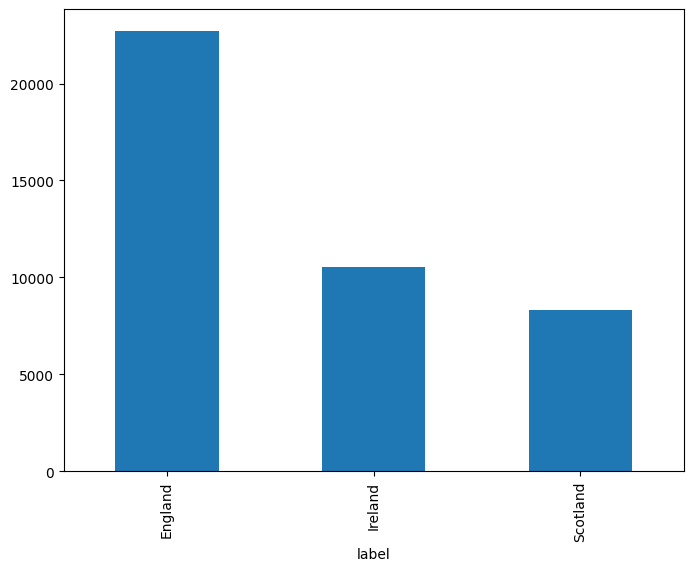

In [38]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 6))
train_data.groupby("label").text.count().plot.bar(ylim=0)
plt.show()

In [39]:
import advertools as adv
from sklearn.feature_extraction.text import TfidfVectorizer

stop_words = []
for key in ["danish", "german", "dutch", "italian", "spanish"]:
    stop_words += list(adv.stopwords[key])


tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm="l2", encoding="latin-1", ngram_range=(1, 2), stop_words=stop_words)

features = tfidf.fit_transform(train_data.text)
labels = train_data.category_id
features.shape


(41570, 150446)

In [40]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(" ")) == 1]
  bigrams = [v for v in feature_names if len(v.split(" ")) == 2]
  # trigrams = [v for v in feature_names if len(v.split(" ")) == 3]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format("\n. ".join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format("\n. ".join(bigrams[-N:])))
  # print("  . Most correlated trigrams:\n. {}".format("\n. ".join(trigrams[-N:])))


# 'England':
  . Most correlated unigrams:
. irland
. irlanda
  . Most correlated bigrams:
. britiske konservative
. escrito votado
# 'Ireland':
  . Most correlated unigrams:
. irland
. irlanda
  . Most correlated bigrams:
. ierse regering
. gobierno irlandés
# 'Scotland':
  . Most correlated unigrams:
. schotland
. escocia
  . Most correlated bigrams:
. votado favor
. escrito votado


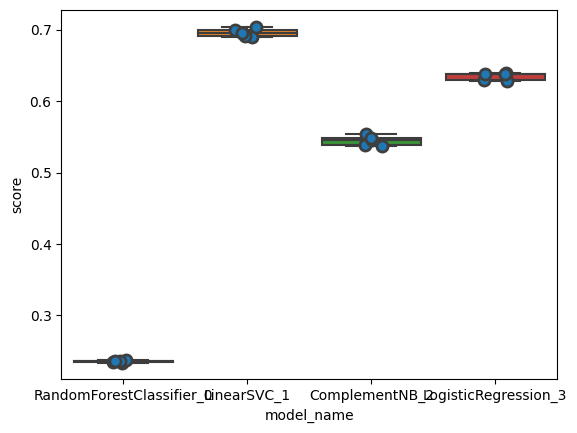

model_name
ComplementNB_2              0.544868
LinearSVC_1                 0.696017
LogisticRegression_3        0.634492
RandomForestClassifier_0    0.235462
Name: score, dtype: float64


In [41]:
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(max_iter=5000),
    ComplementNB(),
    LogisticRegression(random_state=0, max_iter=5000),

    # LinearSVC(max_iter=5000, random_state=21, C=1.5,  penalty="l1", dual=False, class_weight="balanced"),
    
]
kfold = KFold(n_splits=5, shuffle=True, random_state=69420)
entries = []
_scoring = make_scorer(f1_score, average="macro")

for i, model in enumerate(models):
  model_name = f"{model.__class__.__name__}_{i}"
  scores = cross_val_score(model, features, labels, scoring=_scoring, cv=kfold)
  for fold_idx, score in enumerate(scores):
    entries.append((model_name, fold_idx, score))

cv_df = pd.DataFrame(entries, columns=["model_name", "fold_idx", "score"])
sns.boxplot(x="model_name", y="score", data=cv_df)
sns.stripplot(x="model_name", y="score", data=cv_df,
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()
print(cv_df.groupby("model_name").score.mean())


In [44]:
model = LinearSVC()
params = {  "penalty": ["l1","l2"],
            "dual": [True, False],
            "max_iter": [6009],
            "C": [1,5],
            "loss": ['hinge', 'squared_hinge'],
            "multi_class": ["ovr", "crammer_singer"],
            "class_weight": ["balanced", None],
            "random_state": [21]
} 
clf = GridSearchCV(model, params, scoring=_scoring, cv=kfold, return_train_score=True, n_jobs=-1, verbose=2)
clf.fit(features, labels)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


C:\Users\lmg\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
80 fits failed out of a total of 320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\lmg\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\lmg\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "C:\Users\lmg\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py", line 1204, in 

GridSearchCV(cv=KFold(n_splits=5, random_state=69420, shuffle=True),
             estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [1, 5], 'class_weight': ['balanced', None],
                         'dual': [True, False],
                         'loss': ['hinge', 'squared_hinge'], 'max_iter': [6009],
                         'multi_class': ['ovr', 'crammer_singer'],
                         'penalty': ['l1', 'l2'], 'random_state': [21]},
             return_train_score=True,
             scoring=make_scorer(f1_score, average=macro), verbose=2)

In [45]:
clf.best_params_

{'C': 1,
 'class_weight': 'balanced',
 'dual': False,
 'loss': 'squared_hinge',
 'max_iter': 6009,
 'multi_class': 'ovr',
 'penalty': 'l1',
 'random_state': 21}

# TODO:

https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis

https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

https://scikit-learn.org/stable/modules/feature_extraction.html

tfidf

make bow for each language + language detection
 + weighted result
 + train for each language pair


https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py

bigrams+ ?

hashingvectorizer

Stemming and lemmatization